In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import seaborn as sns
import rasterio as rio
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
import disco_tif.process_sb_tiff
import disco_tif.hillshades_pca
import disco_tif.geotiff_plotting
import disco_tif.write_mapfile

In [4]:
import datetime
def nowTime():
    return datetime.datetime.now().strftime("%H:%M:%S")
def now():
    return datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
def snow():
    return datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
def today():
    return datetime.datetime.now().strftime("%Y-%m-%d")
def stoday():
    return datetime.datetime.now().strftime("%Y%m%d")

# define single-band geotiff

In [5]:
tiff_dir = os.getcwd()

single_band_tiff_path = os.path.abspath('../example_data/USGS_LiDAR/USGS_LiDAR.tif')

single_band_tiff_path

'/Users/bbloss/EMeraldCodes/disco-tif/example_data/USGS_LiDAR/USGS_LiDAR.tif'

# grab the hexcolor codes from the file

In [ ]:
EMerald_colors_hex = disco_tif.process_sb_tiff.EMerald_custom_colors_hexcolorcodes
EMerald_colors_hex

In [ ]:
sns.color_palette(EMerald_colors_hex)

# test hex to rgb functionality

In [ ]:
EMerald_colors_rgb = pd.DataFrame()
for ii in range(0, len(EMerald_colors_hex)):
    hexcolor = EMerald_colors_hex[ii]
    EMerald_colors_rgb.loc[ii, ['r','g','b']] = disco_tif.process_sb_tiff.hex_to_rgb(hexcolor)[0], \
                                                disco_tif.process_sb_tiff.hex_to_rgb(hexcolor)[1], \
                                                disco_tif.process_sb_tiff.hex_to_rgb(hexcolor)[2]
EMerald_colors_rgb

In [ ]:
#ii=1
for ii in range(0,len(EMerald_colors_rgb)):
    print(disco_tif.process_sb_tiff.rgb_to_hex(EMerald_colors_rgb.loc[ii, 'r'], EMerald_colors_rgb.loc[ii, 'g'], EMerald_colors_rgb.loc[ii, 'b']))

# inspect colormap generator function

In [ ]:
# read data and minimally process for the colormap function
with rio.open(single_band_tiff_path, 'r') as src:
    data = src.read(1)  # Read the first band
    no_data_value = src.nodata  # Get the no-data value from the GeoTIFF
    epsg_code = src.crs.to_epsg() if src.crs else None
    orig_profile = src.profile
    data_min_max = [np.min(data[data!=no_data_value]), np.max(data)]
    mask = src.read_masks(1)

print(f"no_data_value = {no_data_value}")
print(f"data_min_max = {data_min_max}")
print(f"epsg_code = {epsg_code}")
print(f"src.crs = {src.crs}")
print(f"orig_profile = {orig_profile}")
print(f"mask = {mask}")

In [ ]:
datarange = data_min_max
datarange

In [ ]:
# dataranges to test
#datarange = [-1, 2000]
#datarange = [-1, 4000]
datarange = [-28, 2540]
#datarange = [-285, 4000]
#datarange = [-400, 400]
#datarange = [-400, 0]
#datarange = [-400, -1]
#datarange = [-249, 6]
#datarange = [0, 5000]
#datarange = [0, 500]
#datarange = [0, 255]
#datarange = [0, 60]
#datarange = [0, 54]
#datarange = [1, 1500]
#datarange = [1000, 5000]
#datarange = [200, 100]
#datarange = [100, 200]
#datarange = [44, 255]
#datarange = [-200, 200]

datarange

In [ ]:
data_with_nan = data.copy().astype(float)
if no_data_value is not None:
    data_with_nan[data==no_data_value]=np.nan

np.nanmin(data_with_nan)

In [ ]:
# Clip data values to the specified range
clipped_data = np.clip(data, datarange[0], datarange[1])

# un-clip the orig_data with no_data_vaules to exclude from the perenctile calculations
clipped_data_with_dum = clipped_data.copy()
clipped_data_with_nan = clipped_data.copy().astype(float)
if no_data_value is not None:
    clipped_data_with_dum[data==no_data_value] = no_data_value
    clipped_data_with_nan[data==no_data_value] = np.nan


plt.hist(clipped_data_with_dum.flatten().flatten(), bins=int(min(datarange[1]-datarange[0], 100)))
plt.show()

In [ ]:
# make percentile ranges for pseudo_hist_norm
ph_cmap_method = 'pseudo_hist_norm'

print(f"datarange = {datarange}")
ph_data_breaks = disco_tif.process_sb_tiff.make_percentile_array(data_min_max=datarange,
                                                              data=data,
                                                              no_data_value=no_data_value,
                                                              cmap_method=ph_cmap_method,
                                                              plot_histograms=True)
print(f"ph_data_breaks = {ph_data_breaks}")
ph_percentile_breaks = ((np.array(ph_data_breaks) - datarange[0]) / (datarange[1] - datarange[0])).tolist()
print(f"ph_percentile_breaks = {ph_percentile_breaks}")
EMeraldCustomColorMap = disco_tif.process_sb_tiff.build_EMerald_terrain_colormap(ph_percentile_breaks)
EMeraldCustomColorMap

In [ ]:
# make percentile ranges for pseudo_linear
pl_cmap_method = 'pseudo_linear'

print(f"datarange = {datarange}")
pl_data_breaks = disco_tif.process_sb_tiff.make_percentile_array(data_min_max=datarange,
                                                              data=data,
                                                              no_data_value=no_data_value,
                                                              cmap_method=pl_cmap_method,
                                                              plot_histograms=True)
print(pl_data_breaks)
pl_percentile_breaks = ((np.array(pl_data_breaks) - datarange[0]) / (datarange[1] - datarange[0])).tolist()
print(f"pl_percentile_breaks = {pl_percentile_breaks}")
EMeraldCustomColorMap = disco_tif.process_sb_tiff.build_EMerald_terrain_colormap(pl_percentile_breaks)
EMeraldCustomColorMap

# make look up tables from percentile breaks

In [ ]:
data_breaks = ph_data_breaks
cmap_method = ph_cmap_method

#data_breaks = pl_data_breaks
#cmap_method = pl_cmap_method

lut_no_data_value = no_data_value
lut_no_data_value = None

write_short_files = True

sbpath, ext = os.path.splitext(single_band_tiff_path)
suffix = f"EMeraldCustomColors_{datarange[0]}_to_{datarange[1]}_{cmap_method}"
lut_outpath_base = f"{sbpath}_{suffix}"

In [ ]:
## generate_QGIS_lut:
disco_tif.look_up_tables.rast_dat_to_QGIS_lut(cmap=EMerald_colors_hex,
                                              data_breaks=data_breaks,
                                              dtype=data[0, 0].dtype,
                                              output_GIS_lut_path=lut_outpath_base,
                                              path_to_orig_geotiff=single_band_tiff_path,
                                              short_file=write_short_files,
                                              print_to_screen=True)

In [ ]:
## generate_rgba_luts
# single channel - mulitple files
disco_tif.look_up_tables.rast_dat_to_single_channel_rgba_luts(cmap=EMerald_colors_hex,
                                                              data_breaks=data_breaks,
                                                              dtype=data[0, 0].dtype,
                                                              no_data_value=lut_no_data_value,
                                                              lut_outpath_base=lut_outpath_base,
                                                              short_file=write_short_files,
                                                              print_to_screen=True)

In [ ]:
# mulitple channels - single file
disco_tif.look_up_tables.rast_dat_to_multi_channel_rgba_lut(cmap=EMerald_colors_hex,
                                                            data_breaks=data_breaks,
                                                            dtype=data[0, 0].dtype,
                                                            no_data_value=lut_no_data_value,
                                                            lut_outpath_base=lut_outpath_base,
                                                            short_file=write_short_files,
                                                            print_to_screen=True)

In [ ]:
## generate_data_uint8_lut:
disco_tif.look_up_tables.data_to_uint8_lut(data_breaks=data_breaks,
                                           no_data_value=lut_no_data_value,
                                           lut_outpath_base=lut_outpath_base,
                                           print_to_screen=True)

In [ ]:
## generate single-channel uint8 luts:
disco_tif.look_up_tables.uint8dat_to_single_channel_rgba_luts(cmap=EMerald_colors_hex,
                                                              data_breaks=data_breaks,
                                                              dtype=data[0, 0].dtype,
                                                              no_data_value=lut_no_data_value,
                                                              lut_outpath_base=lut_outpath_base,
                                                              short_file=write_short_files,
                                                              print_to_screen=True)

In [ ]:
## generate multi-channel uint8 luts:
disco_tif.look_up_tables.uint8dat_to_multi_channel_rgba_lut(cmap=EMerald_colors_hex,
                                                            data_breaks=data_breaks,
                                                            dtype=data[0, 0].dtype,
                                                            no_data_value=lut_no_data_value,
                                                            lut_outpath_base=lut_outpath_base,
                                                            short_file=write_short_files,
                                                            print_to_screen=True)

# convert single-band geotiff to rgba geotiff

#### plot original data

In [ ]:
disco_tif.geotiff_plotting.plot_greyband_only(raster_data_dict={'orig' : clipped_data_with_nan},
                                              nrows=1,
                                              ncols=1,
                                              plotsize=9
                                             )

In [6]:
#output_tif = None
output_tif = 'single_band_rgba' # default
#output_tif = 'multi_band_rgba'
#output_tif = 'single_band_rgba multi_band_rgba'

output_QGIS_lut = True # defualt
output_rgba_lut = False # defualt
output_uint8_lut = False # defualt
#output_QGIS_lut = False
#output_rgba_lut = True
#output_uint8_lut = True

plot_rgba_raster = True
#plot_rgba_raster = False # defualt

plot_histograms = True
#plot_histograms = False # default

In [7]:
data_min_max=None # defualt

min_max_method='percentile' # defualt

clip_perc=[1, 99] # defualt

color_palette_name=None # defualt


GIS software compatible color look up table successfully written to: 
	- /Users/bbloss/EMeraldCodes/disco-tif/example_data/USGS_LiDAR/USGS_LiDAR_EMeraldCustomTerrain_2292_to_3017_pseudo_hist_norm_qgis_color_table_7-colors_20240522.txt


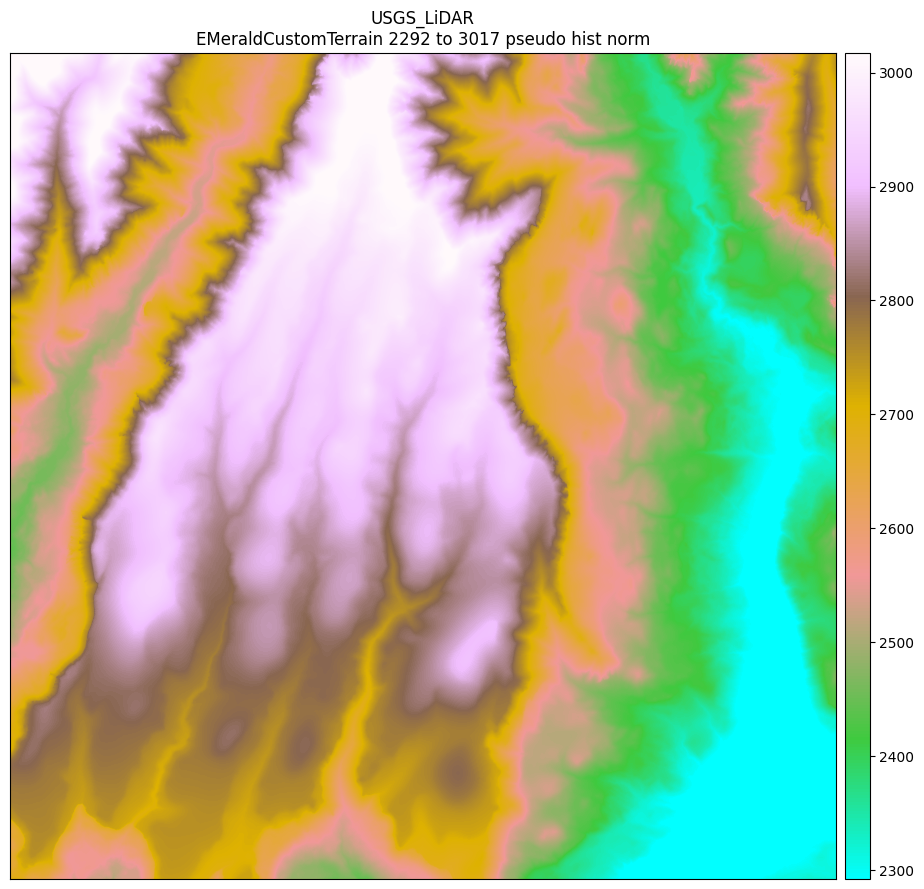


New single-channel colorized geotiff written to: 
	- '/Users/bbloss/EMeraldCodes/disco-tif/example_data/USGS_LiDAR/USGS_LiDAR_EMeraldCustomTerrain_2292_to_3017_pseudo_hist_norm.tif'

ph_data_breaks = 
	[2292.0, 2414.20654296875, 2557.828369140625, 2707.6025390625, 2803.92626953125, 2901.339111328125, 3017.0]
ph_new_file_paths = 
{'single-band-tiff': '/Users/bbloss/EMeraldCodes/disco-tif/example_data/USGS_LiDAR/USGS_LiDAR_EMeraldCustomTerrain_2292_to_3017_pseudo_hist_norm.tif'}


In [8]:
cmap_method='pseudo_hist_norm' # defualt

ph_colormap, ph_data_breaks, ph_new_file_paths = disco_tif.process_sb_tiff.make_rgba_tiff_from_single_Band(single_band_tiff_path,
                                                                                                           #data_min_max=datarange,
                                                                                                           data_min_max=data_min_max,
                                                                                                           cmap_method=cmap_method,
                                                                                                           min_max_method=min_max_method,
                                                                                                           clip_perc=clip_perc,
                                                                                                           color_palette_name=color_palette_name,
                                                                                                           output_tif=output_tif,
                                                                                                           generate_QGIS_lut=output_QGIS_lut,
                                                                                                           generate_rgba_luts=output_rgba_lut,
                                                                                                           generate_data_uint8_lut=output_uint8_lut,
                                                                                                           generate_uint8_luts=output_uint8_lut,
                                                                                                           plot_rgba_raster=plot_rgba_raster,
                                                                                                          )

print(f"ph_data_breaks = \n\t{ph_data_breaks}")
print(f"ph_new_file_paths = \n{ph_new_file_paths}")

In [ ]:
cmap_method='pseudo_linear'

pl_colormap, pl_data_breaks, pl_new_file_paths = disco_tif.process_sb_tiff.make_rgba_tiff_from_single_Band(single_band_tiff_path,
                                                                                                           #data_min_max=datarange,
                                                                                                           data_min_max=data_min_max,
                                                                                                           cmap_method=cmap_method,
                                                                                                           min_max_method=min_max_method,
                                                                                                           clip_perc=clip_perc,
                                                                                                           color_palette_name=color_palette_name,
                                                                                                           output_tif=output_tif,
                                                                                                           generate_QGIS_lut=output_QGIS_lut,
                                                                                                           generate_rgba_luts=output_rgba_lut,
                                                                                                           generate_data_uint8_lut=output_uint8_lut,
                                                                                                           generate_uint8_luts=output_uint8_lut,
                                                                                                           plot_rgba_raster=plot_rgba_raster)

print(f"pl_data_breaks = \n\t{pl_data_breaks}")
print(f"pl_new_file_paths = \n{pl_new_file_paths}")

# build bit for hillshades

In [9]:
# valid azimuths = [0 : 360]
start_az = 90
#num_az_angles = 8
num_az_angles = 6
#num_az_angles = 4

# valid alitudes = [0 : 90]
start_al = 30
al_inc = 30
#num_al_angles = 2
num_al_angles = 1

In [10]:
hs_azimuths, hs_altitudes = disco_tif.hillshades_pca.build_hs_az_al(num_al_angles=num_al_angles,
                                                                    start_az=start_az,
                                                                    num_az_angles=num_az_angles,
                                                                    start_al=start_al,
                                                                    al_inc=al_inc)

azimuths = [30, 90, 150, 210, 270, 330]
altitudes = [30]


In [11]:
data_min_max = [min(ph_data_breaks), max(ph_data_breaks)]
data_min_max

[2292.0, 3017.0]

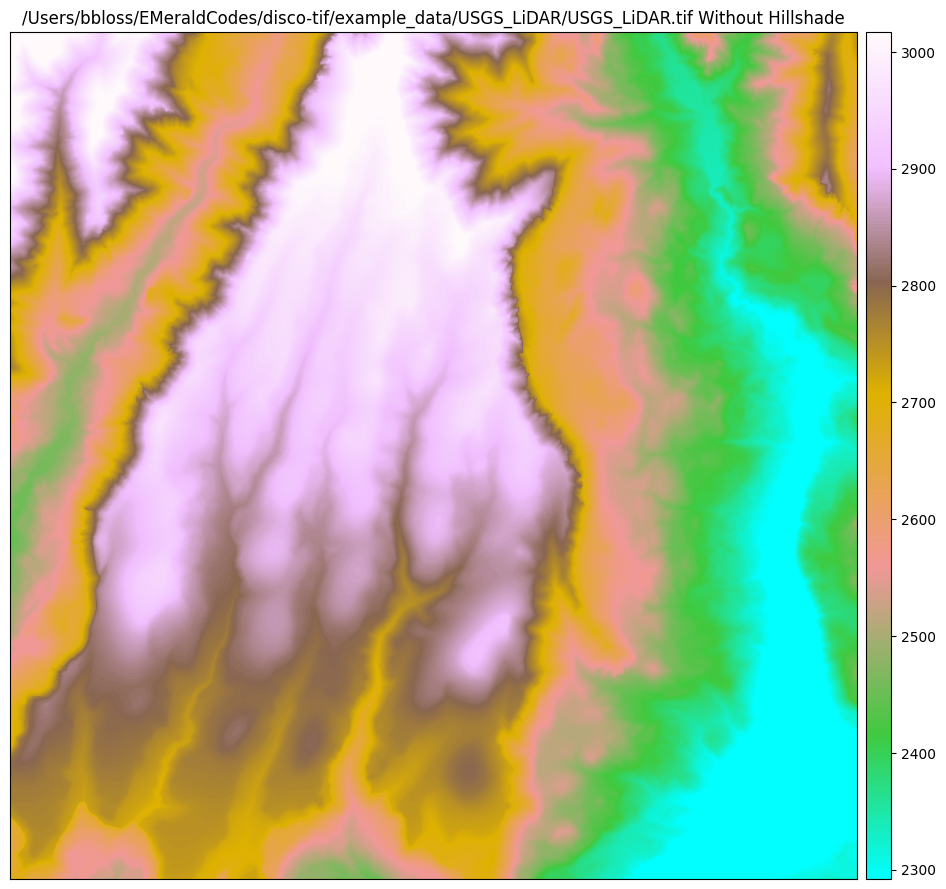

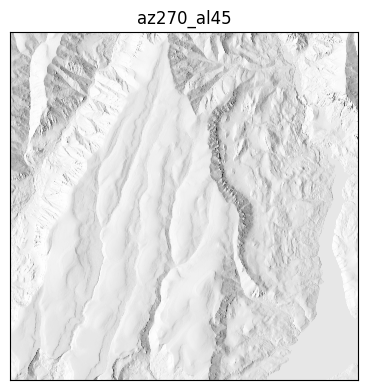

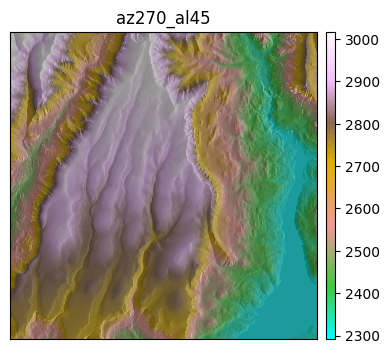

New single-channel geotiff generated successfully: '/Users/bbloss/EMeraldCodes/disco-tif/example_data/USGS_LiDAR/USGS_LiDAR_hillshade_az270_al45.tif'
rasters_dict = {'az270_al45': array([[193.93900006, 194.07856781, 196.28503793, ..., 241.56551515,
        242.39994789, 243.28432759],
       [198.60162931, 197.61615879, 197.47575866, ..., 241.1567704 ,
        242.63251268, 243.59431464],
       [202.9250023 , 200.72912089, 198.47060952, ..., 240.65423829,
        241.80737573, 242.57718312],
       ...,
       [244.98038483, 245.55683428, 245.4458029 , ..., 218.71893897,
        218.50645978, 218.4182386 ],
       [243.29988077, 243.77556818, 244.29787739, ..., 219.73856114,
        219.20780031, 218.46175296],
       [243.51819584, 244.37551738, 244.88006624, ..., 220.86265467,
        219.41198284, 217.67609314]])}
filepaths_dict = {'az270_al45': '/Users/bbloss/EMeraldCodes/disco-tif/example_data/USGS_LiDAR/USGS_LiDAR_hillshade_az270_al45.tif'}


In [12]:
rasters_dict, filepaths_dict = disco_tif.hillshades_pca.build_hillshade(single_band_tiff_path,
                                                               data_min_max,
                                                               hs_azimuths=[270],
                                                               hs_altitudes=[45],
                                                               cmap=ph_colormap,
                                                               #cmap=pl_colormap,
                                                               process_pca=False,
                                                               plot_figures = True)
print(f"rasters_dict = {rasters_dict}")
print(f"filepaths_dict = {filepaths_dict}")

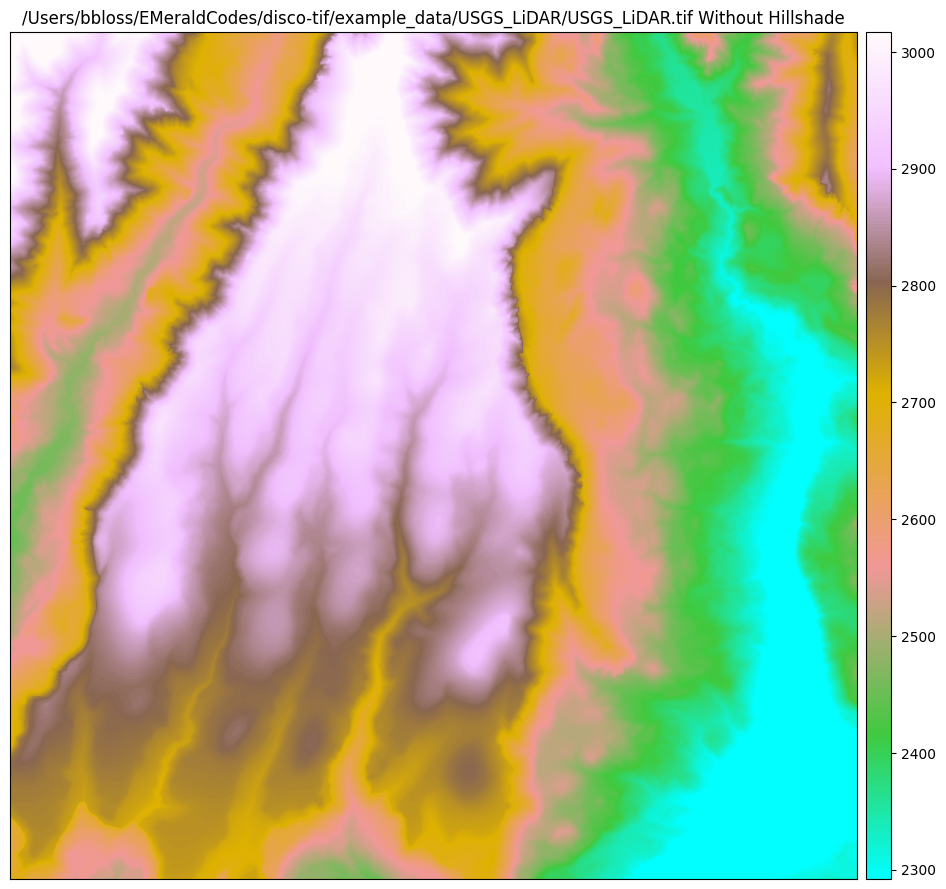

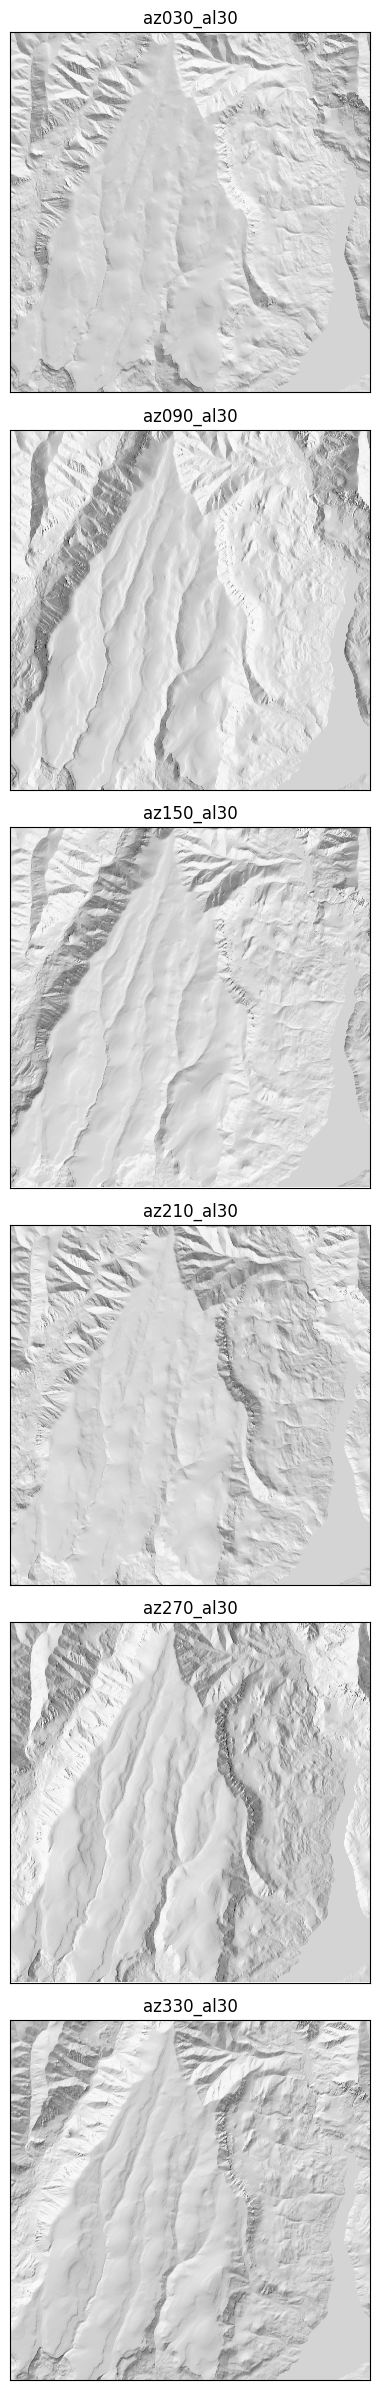

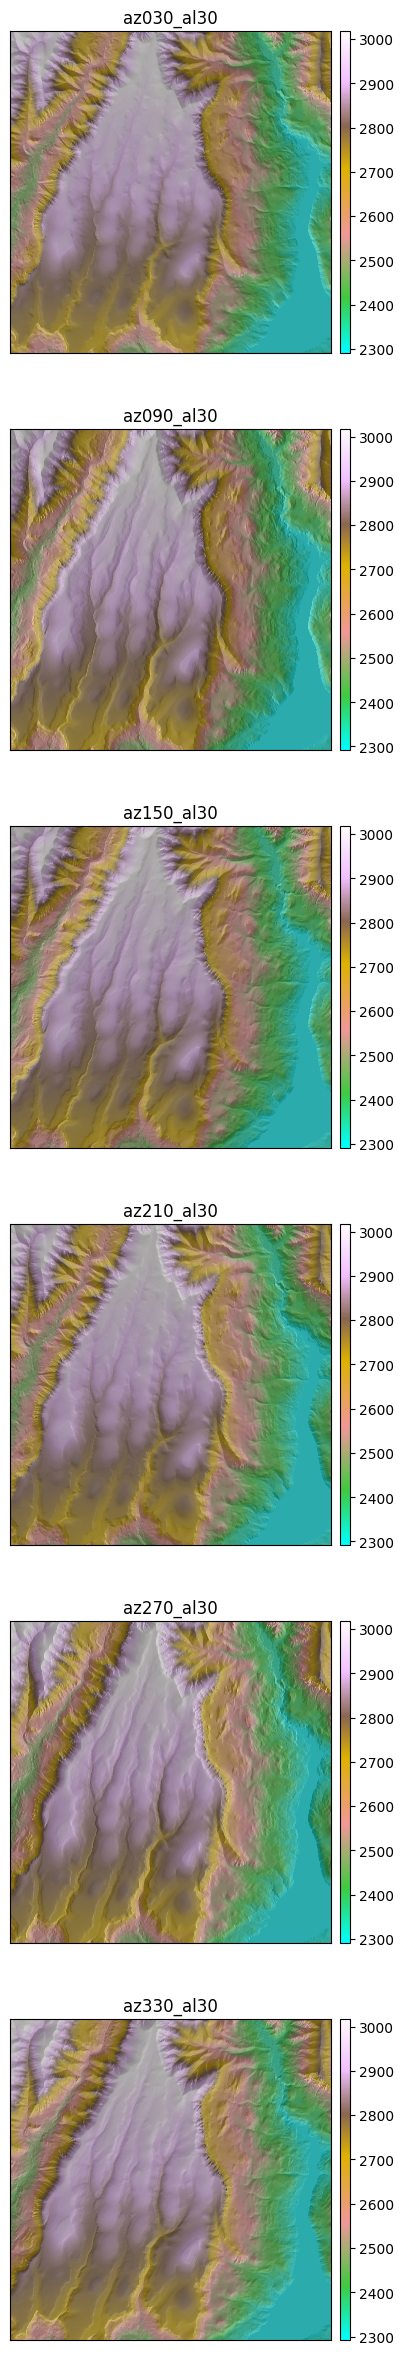

New single-channel geotiff generated successfully: '/Users/bbloss/EMeraldCodes/disco-tif/example_data/USGS_LiDAR/USGS_LiDAR_hillshade_az030_al30.tif'
New single-channel geotiff generated successfully: '/Users/bbloss/EMeraldCodes/disco-tif/example_data/USGS_LiDAR/USGS_LiDAR_hillshade_az090_al30.tif'
New single-channel geotiff generated successfully: '/Users/bbloss/EMeraldCodes/disco-tif/example_data/USGS_LiDAR/USGS_LiDAR_hillshade_az150_al30.tif'
New single-channel geotiff generated successfully: '/Users/bbloss/EMeraldCodes/disco-tif/example_data/USGS_LiDAR/USGS_LiDAR_hillshade_az210_al30.tif'
New single-channel geotiff generated successfully: '/Users/bbloss/EMeraldCodes/disco-tif/example_data/USGS_LiDAR/USGS_LiDAR_hillshade_az270_al30.tif'
New single-channel geotiff generated successfully: '/Users/bbloss/EMeraldCodes/disco-tif/example_data/USGS_LiDAR/USGS_LiDAR_hillshade_az330_al30.tif'


In [ ]:
rasters_dict, filepaths_dict = disco_tif.hillshades_pca.build_hillshade(single_band_tiff_path,
                                                                        data_min_max,
                                                                        hs_azimuths,
                                                                        hs_altitudes,
                                                                        cmap=ph_colormap,
                                                                        process_pca=True,
                                                                        plot_figures=True)

print(f"rasters_dict  = {rasters_dict}")
print(f"filepaths_dict = {filepaths_dict}")

# write a mapsource mapfile filename and write the mapfile

In [ ]:
writeLUTs=True
writeTifs=True
writeHillshades=True

In [ ]:
mapfile_path = f"{single_band_tiff_path.split('.tif')[0]}"
if writeLUTs:
    mapfile_path = f"{mapfile_path}_LUT"
if writeTifs:
    mapfile_path = f"{mapfile_path}_AuxTif"
if writeHillshades:
    mapfile_path = f"{mapfile_path}_HS"


mapfile_path = f"{mapfile_path}.map"

mapfile_path

In [ ]:
disco_tif.write_mapfile.generate_LUT_based_mapfile(single_band_tiff_path, mapfile_path, writeLUTs=writeLUTs, writeTifs=writeTifs, writeHillshades=writeHillshades)

# testing area

In [ ]:
str_r = ''
str_g = ''
str_b = ''
str_a = ''
for indicies in df.index.values:
    str_r = str_r + f"{indicies}:{df.loc[indicies,'r']},"
    str_g = str_g + f"{indicies}:{df.loc[indicies,'g']},"
    str_b = str_b + f"{indicies}:{df.loc[indicies,'b']},"
    str_a = str_a + f"{indicies}:{df.loc[indicies,'a']},"



In [ ]:
#str_r
#str_g
#str_b
str_a


In [ ]:
orig_profile

In [ ]:
orig_profile['nodata']